A well known issue with Sentinel-1 frames as they are distributed is that they are not consistent in time. A fixed-size frame can move along track North or South. This makes time-series enumeration of SLCs for interferograms more complciated.

This notebook takes us through  making the Sentinel-1 "fixed-frames" (or here just "frames") derived from the burst footprints. Bursts are fixed footprints that represent imaging area of the Sentinel-1 IW-mode SAR. The burst map data has generated huge excitement because they represent fixed gegraphic areas through time. The frames that we are defining are a self-imposed organization scheme to allow us to perform large regional scale time-series analysis at roughly the scale of the originally distributed ESA frames.

The burst maps are downloaded from ESA [page](https://sar-mpc.eu/test-data-sets/). We downloaded `S1_burstid_20220530`.

There is some discussion about the metadata found in this table the next notebook. Here, we jumping right to do it to take each burst (across all three swaths) and collect them into a group of 10 within a "frame" so that each frame has a 2 burst overlap. Of course, the number of bursts within a frame and of overlapping neighboring frames could easily be re-configured here. These are based on the approximate size of frames as they are currently distributed via ESA.

In [1]:
import sqlite3
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from dem_stitcher.datasets import get_dem_tile_extents
from rasterio.crs import CRS
import warnings

# Parameters

In [2]:
N_BURSTS_PER_FRAME = 8
N_BURSTS_PER_OVERLAP = 2

# Read Burst Data

The data needs to be unzipped first in this directory.

In [3]:
%%time

# SQL must wrap the geometry in hex(st_asbinary(...))
sql = "SELECT * FROM burst_id_map;"
con = sqlite3.connect("S1_burstid_20220530/IW/sqlite/burst_map_IW_000001_375887.sqlite3")

df_burst = gpd.GeoDataFrame.from_postgis(sql, con, geom_col="GEOMETRY")

CPU times: user 8.75 s, sys: 634 ms, total: 9.38 s
Wall time: 9.45 s


In [4]:
df_burst.head()

,OGC_FID,GEOMETRY,burst_id,subswath_name,relative_orbit_number,time_from_anx_sec,orbit_pass
0,1,"MULTIPOLYGON Z (((3.36758 0.75322 0.00000, 3.7...",1,IW1,1,2.301015,ASCENDING
1,2,"MULTIPOLYGON Z (((4.09178 0.97402 0.00000, 4.5...",1,IW2,1,3.133218,ASCENDING
2,3,"MULTIPOLYGON Z (((4.85545 1.19200 0.00000, 5.2...",1,IW3,1,4.211255,ASCENDING
3,4,"MULTIPOLYGON Z (((3.33269 0.92005 0.00000, 3.7...",2,IW1,1,5.059288,ASCENDING
4,5,"MULTIPOLYGON Z (((4.05690 1.14071 0.00000, 4.4...",2,IW2,1,5.891491,ASCENDING


# Burst Aggregation

Each burst covers three swaths. So we want to merge these bursts together as a single geometric object.

<AxesSubplot: >

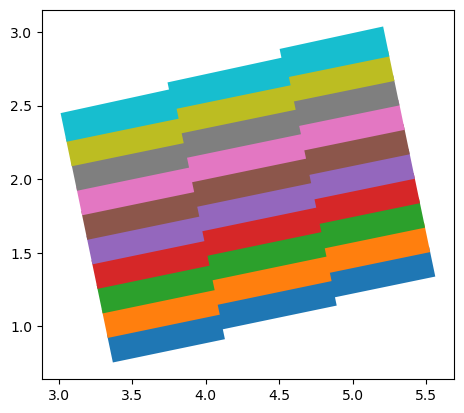

In [5]:
df_burst.head(30).plot(column='burst_id', categorical=True)

In [6]:
%%time

def join_track_numbers(orbits: list) -> str:
    orbits = list(set(orbits))
    orbits_str = list(map(str, orbits))
    return ','.join(orbits_str)


df_burst_triplet_temp = df_burst.dissolve(by='burst_id', 
                                          aggfunc={'OGC_FID': ['min', 'max'],
                                                   'relative_orbit_number': join_track_numbers,
                                                   'orbit_pass': 'first'}, 
                                          as_index=False)

CPU times: user 52.2 s, sys: 645 ms, total: 52.8 s
Wall time: 52.2 s


We keep store this as an alternative dataframe because we want to rename columns.

In [7]:
df_burst_triplet_temp.head()

,burst_id,GEOMETRY,"(OGC_FID, min)","(OGC_FID, max)","(relative_orbit_number, join_track_numbers)","(orbit_pass, first)"
0,1,"POLYGON Z ((4.12960 0.91167 0.00000, 3.76300 0...",1,3,1,ASCENDING
1,2,"POLYGON Z ((4.09471 1.07835 0.00000, 3.72810 1...",4,6,1,ASCENDING
2,3,"POLYGON Z ((4.05984 1.24503 0.00000, 3.69323 1...",7,9,1,ASCENDING
3,4,"POLYGON Z ((4.02501 1.41172 0.00000, 3.65839 1...",10,12,1,ASCENDING
4,5,"POLYGON Z ((3.99020 1.57841 0.00000, 3.62357 1...",13,15,1,ASCENDING


In [8]:
df_burst_triplet = df_burst_triplet_temp.reset_index(drop=True)
df_burst_triplet.columns = ['burst_id', 
                            'geometry', 
                            'OGC_FID_min', 
                            'OGC_FID_max', 
                            'relative_orbit_numbers', 
                            'look_direction']
df_burst_triplet.head()

,burst_id,geometry,OGC_FID_min,OGC_FID_max,relative_orbit_numbers,look_direction
0,1,"POLYGON Z ((4.12960 0.91167 0.00000, 3.76300 0...",1,3,1,ASCENDING
1,2,"POLYGON Z ((4.09471 1.07835 0.00000, 3.72810 1...",4,6,1,ASCENDING
2,3,"POLYGON Z ((4.05984 1.24503 0.00000, 3.69323 1...",7,9,1,ASCENDING
3,4,"POLYGON Z ((4.02501 1.41172 0.00000, 3.65839 1...",10,12,1,ASCENDING
4,5,"POLYGON Z ((3.99020 1.57841 0.00000, 3.62357 1...",13,15,1,ASCENDING


We are going to assign the dataframe a CRS. Seems to get lost in our initial read of the data.

In [9]:
df_burst_triplet = gpd.GeoDataFrame(df_burst_triplet,
                                    geometry=df_burst_triplet['geometry'],
                                    crs=CRS.from_epsg(4326))
df_burst_triplet.head()

,burst_id,geometry,OGC_FID_min,OGC_FID_max,relative_orbit_numbers,look_direction
0,1,"POLYGON Z ((4.12960 0.91167 0.00000, 3.76300 0...",1,3,1,ASCENDING
1,2,"POLYGON Z ((4.09471 1.07835 0.00000, 3.72810 1...",4,6,1,ASCENDING
2,3,"POLYGON Z ((4.05984 1.24503 0.00000, 3.69323 1...",7,9,1,ASCENDING
3,4,"POLYGON Z ((4.02501 1.41172 0.00000, 3.65839 1...",10,12,1,ASCENDING
4,5,"POLYGON Z ((3.99020 1.57841 0.00000, 3.62357 1...",13,15,1,ASCENDING


In [10]:
n_bursts = N_BURSTS_PER_FRAME
o_bursts = N_BURSTS_PER_OVERLAP
M = df_burst_triplet.burst_id.max()
N = int(np.ceil(M / (n_bursts - o_bursts)))

starts = [k * (n_bursts - o_bursts) for k in range(N)]

In [11]:
slices = [df_burst_triplet.iloc[start: start+ n_bursts] for start in tqdm(starts)]

100%|██████████████████████████| 62648/62648 [00:28<00:00, 2196.77it/s]


The `aggfunc` does make this slower geometry dissolve slower. We filter out future warnings as well as this needs to be resolved in the `geopandas` library.

In [12]:
def join_track_numbers(orbits: list) -> str:
    orbits = list(set(orbits))
    orbits_str = sorted(list(map(str, orbits)))
    return ','.join(orbits_str)


def join_look_direction(look_direction_l: list) -> str:
    return ','.join(list(set(look_direction_l)))

In [13]:
agg_dict = {'OGC_FID_min': 'min',
            'OGC_FID_max': 'max',
            'burst_id': ['min', 'max'],
            'relative_orbit_numbers': join_track_numbers,
            'look_direction': join_look_direction}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    frames_l = [df_s.dissolve(aggfunc=agg_dict) for df_s in tqdm(slices)]

100%|███████████████████████████| 62648/62648 [07:09<00:00, 146.00it/s]


In [14]:
df_frames_temp = pd.concat(frames_l, axis=0)
df_frames_temp.head()

,geometry,"(OGC_FID_min, min)","(OGC_FID_max, max)","(burst_id, min)","(burst_id, max)","(relative_orbit_numbers, join_track_numbers)","(look_direction, join_look_direction)"
0,"POLYGON Z ((3.33269 0.92005 0.00000, 3.33269 0...",1,24,1,8,1,ASCENDING
0,"POLYGON Z ((3.12380 1.92112 0.00000, 3.12380 1...",19,42,7,14,1,ASCENDING
0,"POLYGON Z ((2.91374 2.92186 0.00000, 2.91374 2...",37,60,13,20,1,ASCENDING
0,"POLYGON Z ((2.70450 3.92269 0.00000, 2.70450 3...",55,78,19,26,1,ASCENDING
0,"POLYGON Z ((2.49742 4.92387 0.00000, 2.49611 4...",73,96,25,32,1,ASCENDING


Format the frames.

In [15]:
df_frames = df_frames_temp.reset_index(drop=True)
df_frames.columns = ['geometry', 
                     'OGC_FID_min', 
                     'OGC_FID_max', 
                     'burst_id_min', 
                     'burst_id_max', 
                     'relative_orbit_numbers',
                     'look_direction']
# reorder columns
df_frames = df_frames[[col for col in df_frames.columns if col != 'geometry'] + ['geometry']]
df_frames.head()

,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,geometry
0,1,24,1,8,1,ASCENDING,"POLYGON Z ((3.33269 0.92005 0.00000, 3.33269 0..."
1,19,42,7,14,1,ASCENDING,"POLYGON Z ((3.12380 1.92112 0.00000, 3.12380 1..."
2,37,60,13,20,1,ASCENDING,"POLYGON Z ((2.91374 2.92186 0.00000, 2.91374 2..."
3,55,78,19,26,1,ASCENDING,"POLYGON Z ((2.70450 3.92269 0.00000, 2.70450 3..."
4,73,96,25,32,1,ASCENDING,"POLYGON Z ((2.49742 4.92387 0.00000, 2.49611 4..."


<AxesSubplot: >

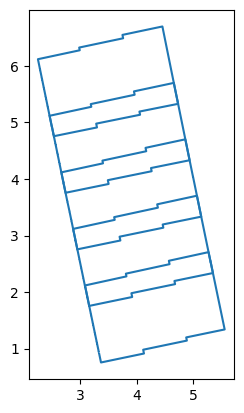

In [16]:
df_frames.iloc[:5].boundary.plot()

(2.0837540999999997, 5.7261159, 0.4559446, 6.9959153999999995)

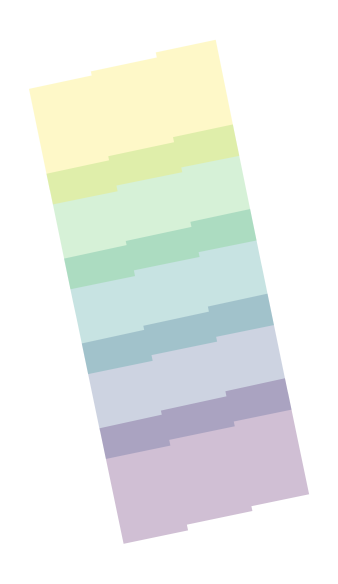

In [17]:
fig, ax = plt.subplots(dpi=150)
df_frames.iloc[:5].plot(column='burst_id_min', alpha=.25, ax=ax)
ax.axis('off')


# Land Intersection

We are going to read a 1 degree buffered land area. This should encompass all land areas relevant for the product. We use this same mask (at full resolution) for the browse imagery.

In [18]:
%%time

df_land = gpd.read_file('usgs_land_1deg_buffered.geojson')    
land_geo = df_land.geometry.unary_union

CPU times: user 2.27 s, sys: 473 ms, total: 2.74 s
Wall time: 513 ms


In [19]:
%%time

# ind_land = df_frames.geometry.intersects(land_geo)

# below replaces the above
# Credit to Scott Staniewicz (@scottstanie)
# Requires shapely>=2.0.0
from shapely import STRtree

tree = STRtree(df_frames.geometry)
idxs_land = tree.query(land_geo, predicate="intersects")

CPU times: user 297 ms, sys: 7.2 ms, total: 305 ms
Wall time: 303 ms


In [20]:
df_frames_land = df_frames.iloc[idxs_land].copy()
# Wonky indexing with STRtree
df_frames_land.sort_values(by='OGC_FID_min', inplace=True)
df_frames_land = df_frames_land.reset_index(drop=True)
df_frames_land.head()

,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,geometry
0,37,60,13,20,1,ASCENDING,"POLYGON Z ((2.91374 2.92186 0.00000, 2.91374 2..."
1,55,78,19,26,1,ASCENDING,"POLYGON Z ((2.70450 3.92269 0.00000, 2.70450 3..."
2,73,96,25,32,1,ASCENDING,"POLYGON Z ((2.49742 4.92387 0.00000, 2.49611 4..."
3,91,114,31,38,1,ASCENDING,"POLYGON Z ((2.28948 5.92481 0.00000, 2.28948 5..."
4,109,132,37,44,1,ASCENDING,"POLYGON Z ((2.08218 6.92580 0.00000, 2.08218 6..."


Now that we have the total frames - we are going to assign frame ids.

<AxesSubplot: >

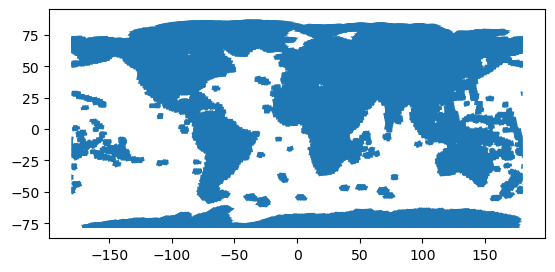

In [21]:
df_frames_land.plot()

In [22]:
df_frames_land = df_frames_land.reset_index(drop=False)
df_frames_land.rename(columns={'index': 'frame_id'}, inplace=True)

(-198.0, 198.00000000000006, -98.8621064, 96.1042344)

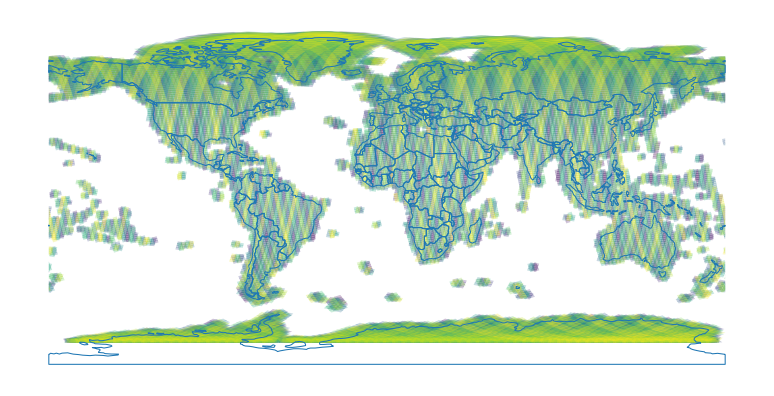

In [23]:
fig, ax = plt.subplots(dpi=150)
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_frames_land.plot(column='burst_id_min', alpha=.25, ax=ax)

df_world.boundary.plot(ax=ax, lw=.5)
ax.axis('off')


# Dateline Fix

We take the multipolygons at the dateline and make sure we have geometries at the left and right hemispheres. This will mean we don't have to take care of this during enumeration of IFGs.

In [24]:
buffer = 5

In [25]:
df_dateline = df_frames_land.cx[:-180 + buffer,:]
df_dateline.head()

,frame_id,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,geometry
79,79,1909,1932,637,644,1,DESCENDING,"MULTIPOLYGON Z (((-174.34564 71.53211 0.00000,..."
80,80,1927,1950,643,650,1,DESCENDING,"MULTIPOLYGON Z (((-176.24122 70.60947 0.00000,..."
81,81,1945,1968,649,656,1,DESCENDING,"MULTIPOLYGON Z (((-176.96186 69.63870 0.00000,..."
82,82,1963,1986,655,662,1,DESCENDING,"MULTIPOLYGON Z (((-177.59767 68.71217 0.00000,..."
83,83,1981,2004,661,668,1,DESCENDING,"MULTIPOLYGON Z (((-178.25506 67.69156 0.00000,..."


In [26]:
multipolygon_index = df_dateline.geometry.map(lambda geo: (geo.geom_type != 'Polygon'))
df_dateline_multi = df_dateline[multipolygon_index].copy()

These plots show how the frames at the dateline are concatentated. There "missing" portion is in the right hemisphere.

(-70.0, 50.0)

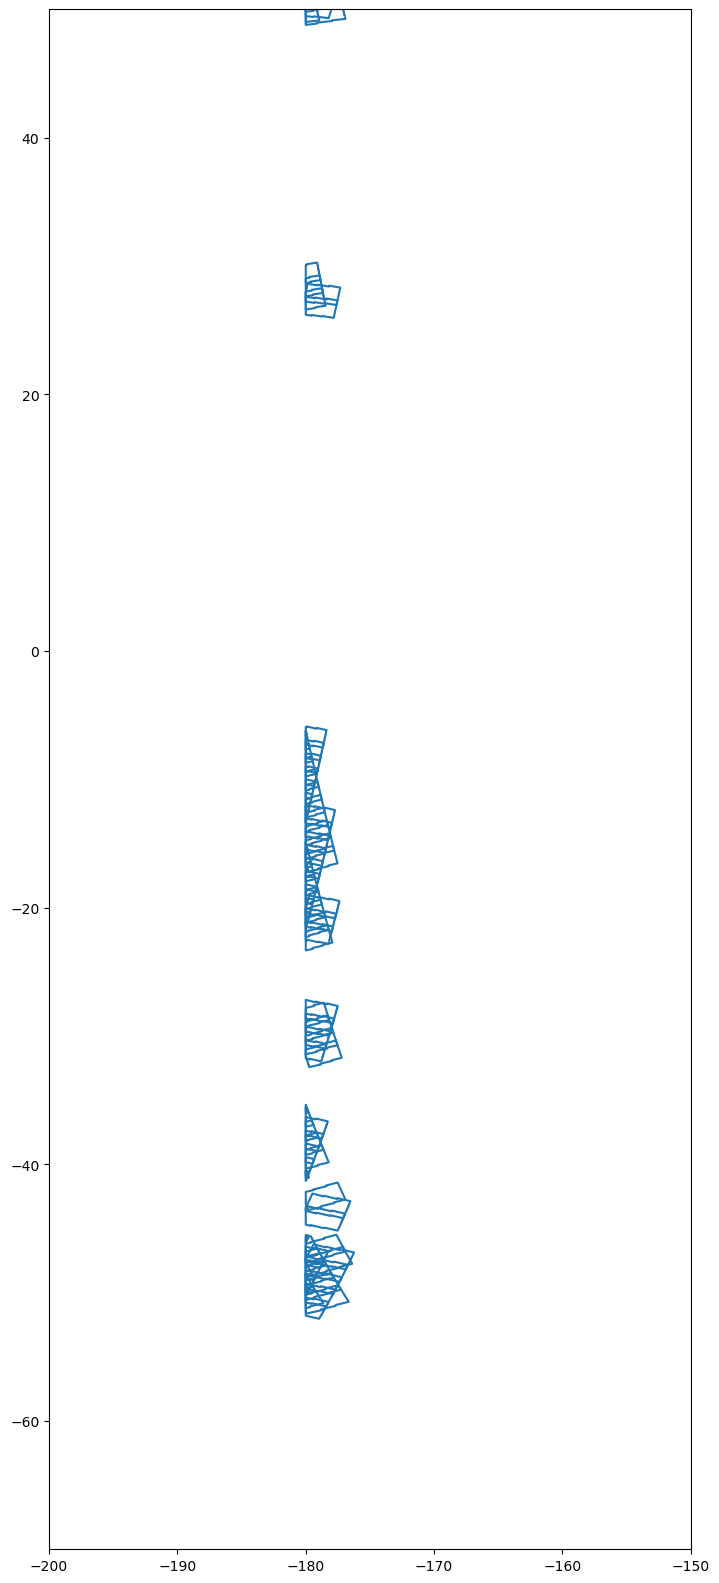

In [27]:
fig, ax = plt.subplots(figsize=(10, 20))
df_dateline_multi.boundary.plot(ax=ax)
ax.set_xlim(-200, -150)
ax.set_ylim(-70, 50)

In [28]:
df_dateline_l = df_dateline_multi.copy()
df_dateline_r = df_dateline_multi.copy()

# The buffer ensures there is some overlap for merging by frame id
geo_l = df_dateline_multi.translate(xoff=-360).buffer(1e-7)
df_dateline_l.geometry = df_dateline_multi.geometry.union(geo_l)
df_dateline_l_f = df_dateline_l.dissolve(by='frame_id', aggfunc='first').explode(index_parts=False)
# only want the areas that are at the left hemisphere dateline
df_dateline_l_f = df_dateline_l_f.cx[-180- 80:-180 + buffer, :].reset_index(drop=False)

geo_r = df_dateline_multi.translate(xoff=360).buffer(1e-7)
df_dateline_r.geometry = df_dateline_multi.geometry.union(geo_r)
df_dateline_r_f = df_dateline_r.dissolve(by='frame_id', aggfunc='first').explode(index_parts=False)
# only want the areas that are at the right hemisphere dateline
df_dateline_r_f = df_dateline_r_f.cx[180 - buffer: 180 + 80, :].reset_index(drop=False)

/var/folders/s6/fbsc26cd0ddffbp3_knts_9c0wcxj1/T/ipykernel_62601/1531954237.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_l = df_dateline_multi.translate(xoff=-360).buffer(1e-7)
/var/folders/s6/fbsc26cd0ddffbp3_knts_9c0wcxj1/T/ipykernel_62601/1531954237.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_r = df_dateline_multi.translate(xoff=360).buffer(1e-7)


In [29]:
df_dateline_l_f.head()

,frame_id,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,geometry
0,79,1909,1932,637,644,1,DESCENDING,"POLYGON Z ((-176.73873 71.67903 0.00000, -177...."
1,80,1927,1950,643,650,1,DESCENDING,"POLYGON Z ((-178.60410 70.72891 0.00000, -179...."
2,81,1945,1968,649,656,1,DESCENDING,"POLYGON Z ((-179.21899 69.75242 0.00000, -180...."
3,82,1963,1986,655,662,1,DESCENDING,"POLYGON Z ((-179.75609 68.83300 0.00000, -179...."
4,83,1981,2004,661,668,1,DESCENDING,"POLYGON Z ((-180.00000 67.83176 0.00000, -180...."


These few plots summarize our geometric manipulations showing the how we merged at each hemisphere.

(-70.0, 50.0)

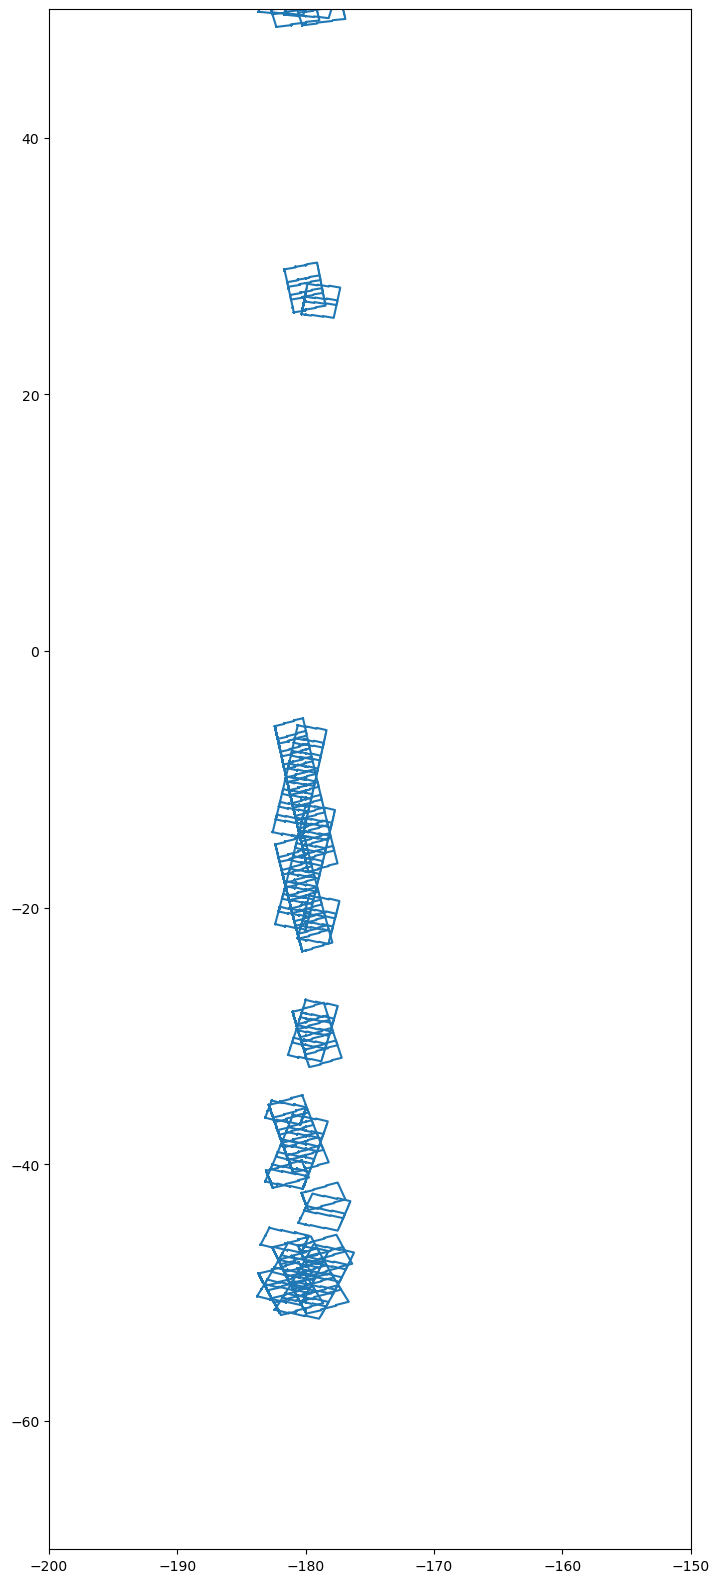

In [30]:
fig, ax = plt.subplots(figsize=(10, 20))

df_dateline_l_f.boundary.plot(ax = ax)
ax.set_xlim(-200, -150)
ax.set_ylim(-70, 50)

(-70.0, 50.0)

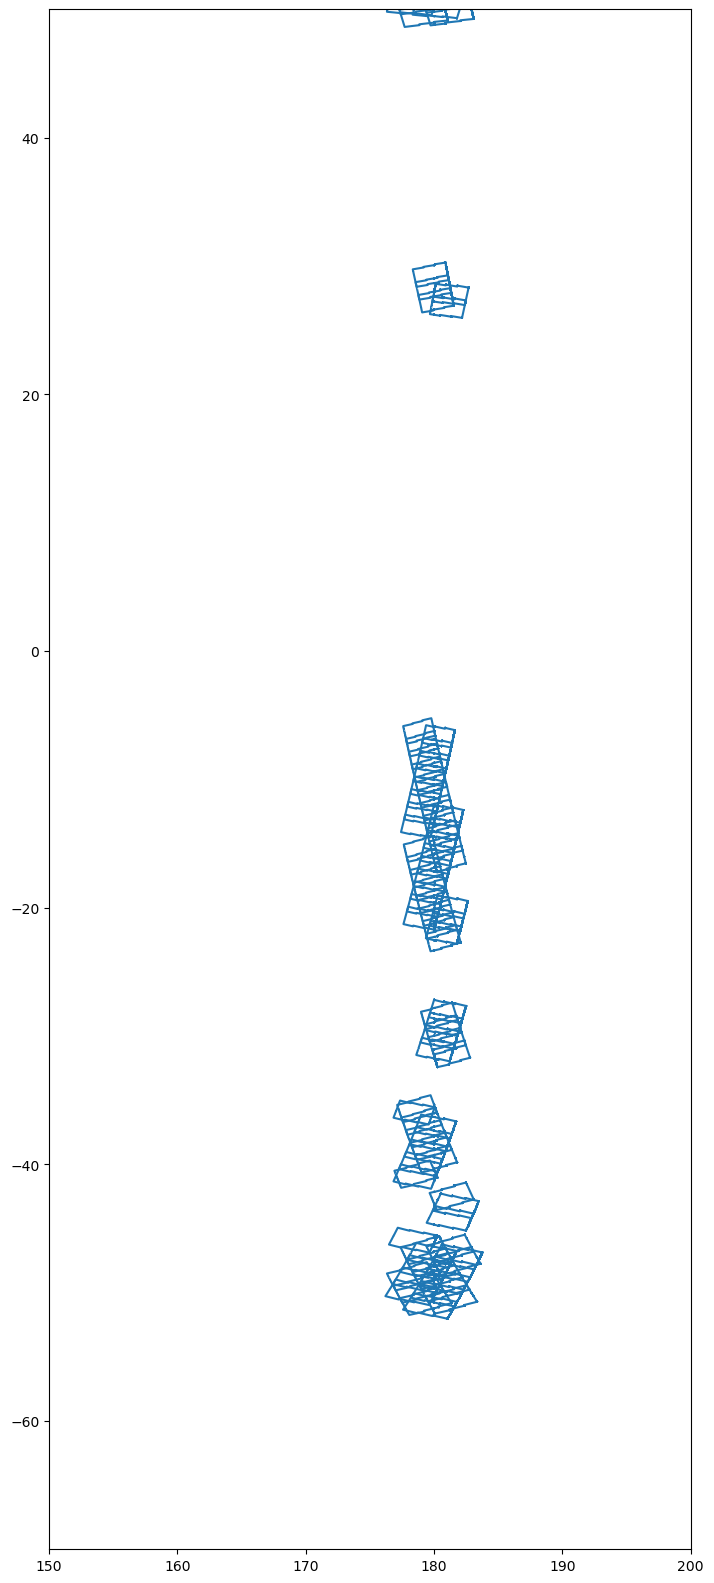

In [31]:
fig, ax = plt.subplots(figsize=(10, 20))

df_dateline_r_f.boundary.plot(ax = ax)
ax.set_xlim(150, 200)
ax.set_ylim(-70, 50)

In [32]:
frame_ids_l = df_dateline_l_f.frame_id.tolist()
frame_ids_r = df_dateline_r_f.frame_id.tolist()
frame_ids_dateline = list(set(frame_ids_l + frame_ids_r))

In [33]:
dateline_ind = df_frames_land.frame_id.isin(frame_ids_dateline)
df_dateline_removed = df_frames_land[~dateline_ind].copy()
dfs = [df_dateline_removed, df_dateline_r_f, df_dateline_l_f]
df_frames_final = pd.concat(dfs, axis=0).reset_index(drop=True)
df_frames_final.head()

,frame_id,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,geometry
0,0,37,60,13,20,1,ASCENDING,"POLYGON Z ((2.91374 2.92186 0.00000, 2.91374 2..."
1,1,55,78,19,26,1,ASCENDING,"POLYGON Z ((2.70450 3.92269 0.00000, 2.70450 3..."
2,2,73,96,25,32,1,ASCENDING,"POLYGON Z ((2.49742 4.92387 0.00000, 2.49611 4..."
3,3,91,114,31,38,1,ASCENDING,"POLYGON Z ((2.28948 5.92481 0.00000, 2.28948 5..."
4,4,109,132,37,44,1,ASCENDING,"POLYGON Z ((2.08218 6.92580 0.00000, 2.08218 6..."


# Serialization

Uncomment to inspect.

In [34]:
# df_frames_final.to_file('s1-frames.geojson', driver='GeoJSON')

# Compressed serialization

This compresses the geojson into gzip format so it can be included in the package for easily.

In [35]:
from dem_stitcher.geojson_io import to_geojson_gzip

In [36]:
to_geojson_gzip(df_frames_final, 's1_frames.geojson.gzip')

's1_frames.geojson.gzip'